## Calculating BER/BLER for PDSCH Communication with LDPC
This notebook shows how to calculate the bit error rate of PDSCH communication with LDPC channel coding.

In [1]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, LdpcEncoder, Grid, random


In [2]:
numFrames = 4                               # Number of time-domain frames
ebNoDbs = range(-2,4)                       # Eb/No values (in dB)
freqDomain = False                          # Set to True to apply channel in frequency domain

modulation = "16QAM"
carrier = Carrier(numRbs=51, spacing=30)    # Create a carrier with 51 RBs and 30KHz subcarrier spacing
bwp = carrier.curBwp                        # The only bandwidth part in the carrier

# Create a PDSCH object
pdsch = PDSCH(bwp, interleavingBundleSize=0, numLayers=2, nID=carrier.cellId, modulation=modulation)
pdsch.setDMRS(prgSize=0, configType=2, additionalPos=2)     # Specify the DMRS configuration

# Create the LDPC encoder
codeRate = 490/1024
ldpcEncoder = LdpcEncoder(baseGraphNo=1, modulation=pdsch.modems[0].modulation, 
                          txLayers=pdsch.numLayers, targetRate=codeRate)
ldpcDecoder = ldpcEncoder.getDecoder()

numSlots = bwp.slotsPerFrame*numFrames
results = {}
for chanEstMethod in ["Perfect", "LS"]:                 # Two channel estimation methods
    results[chanEstMethod] = {}
    print("\nSimulating end-to-end for \"%s\", with \"%s\" channel estimation, in %s domain."%
          (modulation, chanEstMethod, "frequency" if freqDomain else "time"))
    print("EB/No(dB)  Total Bits  Bit Errors  BER(%)  Total Blocks  Block Errors  BLER(%)  time(Sec.)")
    print("---------  ----------  ----------  ------  ------------  ------------  -------  ----------")
    for ebNoDb in ebNoDbs:                              # For each Eb/No value in ebNoDbs
        snrDb = ebNoDb + 10*np.log10(pdsch.modems[0].qm * codeRate * bwp.dataTimeRatio) # Eb/No -> SNR
        random.setSeed(123)                             # Making the results reproducible for each Eb/No
        t0 = time.time()                                # Start time for each Eb/No
        carrier.slotNo = 0

        # Creating a CdlChannel object:
        channel = CdlChannel(bwp, 'C', delaySpread=300, carrierFreq=4e9, dopplerShift=5,
                             txAntenna = AntennaPanel([2,4]),  # 8 TX antenna
                             rxAntenna = AntennaPanel([1,2]),  # 2 RX antenna
                             seed = 123)  

        blockErrors = 0
        totalBlocks = 0
        bitErrors = 0
        totalBits = 0

        for slotNo in range(numSlots):
            grid = pdsch.getGrid()                       # Create a resource grid already populated with DMRS 
            txBlockSize = pdsch.getTxBlockSize(codeRate) # Calculate the Transport Block Size
            txBlock = random.bits(txBlockSize[0])        # Create random binary data
            numBits = pdsch.getBitSizes(grid)            # Actual number of bits available in the resource grid

            # Perform the segmentation, rate-matching, and encoding
            rateMatchedCodeWords = ldpcEncoder.getRateMatchedCodeWords(txBlock, numBits[0])

            pdsch.populateGrid(grid, rateMatchedCodeWords)   # Map/modulate the data to the resource grid

            # Store the indexes of the PDSCH data in pdschIndexes to be used later.
            pdschIndexes = pdsch.getReIndexes(grid, "PDSCH")   

            # Getting the Precoding Matrix, and precoding the resource grid
            channelMatrix = channel.getChannelMatrix()              # Get the channel matrix
            precoder = pdsch.getPrecodingMatrix(channelMatrix)      # Get the precoder matrix from the PDSCH object
            precodedGrid = grid.precode(precoder)                   # Perform the precoding

            if freqDomain:
                rxGrid = precodedGrid.applyChannel(channelMatrix)   # Apply the channel in frequency domain
                rxGrid = rxGrid.addNoise(snrDb=snrDb)               # Add noise
            else:
                txWaveform = precodedGrid.ofdmModulate()            # OFDM Modulation
                maxDelay = channel.getMaxDelay()                    # Get the max. channel delay
                txWaveform = txWaveform.pad(maxDelay)               # Pad with zeros
                rxWaveform = channel.applyToSignal(txWaveform)      # Apply channel in time domain
                noisyRxWaveform = rxWaveform.addNoise(snrDb=snrDb, nFFT=bwp.nFFT)  # Add noise
                offset = channel.getTimingOffset()                  # Get timing info for synchronization
                syncedWaveform = noisyRxWaveform.sync(offset)       # Synchronization
                rxGrid = syncedWaveform.ofdmDemodulate(bwp)         # OFDM demodulation

                
            if chanEstMethod == "Perfect":                          # Perfect Channel Estimation
                estChannelMatrix = channelMatrix @ precoder[None,...]
            else:                                                   # LS + Interpolation Channel Estimation
                estChannelMatrix, noiseEst = rxGrid.estimateChannelLS(pdsch.dmrs, polarInt=False, 
                                                                      kernel='linear')
                                                                      
            eqGrid, llrScales = rxGrid.equalize(estChannelMatrix)            # Equalization
            llrs = pdsch.getLLRsFromGrid(eqGrid, pdschIndexes, llrScales)    # Demodulation (to LLRs)
            rxCodedBlocks = ldpcDecoder.recoverRate(llrs[0], txBlockSize[0]) # Recovering Rate
            decodedBlocks = ldpcDecoder.decode(rxCodedBlocks, numIter=20)    # LDPC Decoding
            decodedTxBlockWithCRC, crcMatch = ldpcDecoder.checkCrcAndMerge(decodedBlocks) # Merge blocks
            decodedTxBlock = decodedTxBlockWithCRC[:-24]                     # remove transport block CRC
            blockErrors += len(crcMatch)-sum(crcMatch)                       # Number of Block errors
            bitErrors += np.abs(decodedTxBlock-txBlock).sum()                # Number of bit errors
            totalBlocks += len(crcMatch)
            totalBits += len(txBlock)
            
            ber = bitErrors*100/totalBits
            bler = blockErrors*100/totalBlocks
            print("\r  %3d      %8d    %8d    %6.2f    %8d      %8d     %6.2f     %6.2f"
                  %(ebNoDb, totalBits, bitErrors, ber, totalBlocks, blockErrors, bler, time.time()-t0), end='')

            carrier.goNext()
            channel.goNext()

        dt = time.time()-t0
        results[chanEstMethod][snrDb] = {"totalBits":  totalBits, 
                                         "bitErrors":  bitErrors, 
                                         "BER":        bitErrors*100/totalBits,
                                         "totalBlocks":totalBlocks, 
                                         "blockErrors":blockErrors, 
                                         "BLER":       blockErrors*100/totalBlocks,
                                         "Time":       dt}
        print("\r  %3d      %8d    %8d    %6.2f    %8d      %8d     %6.2f     %6.2f"
              %(ebNoDb, totalBits, bitErrors, ber, totalBlocks, blockErrors, bler, time.time()-t0))



Simulating end-to-end for "16QAM", with "Perfect" channel estimation, in time domain.
EB/No(dB)  Total Bits  Bit Errors  BER(%)  Total Blocks  Block Errors  BLER(%)  time(Sec.)
---------  ----------  ----------  ------  ------------  ------------  -------  ----------
   -2       2417280      230262      9.53         320           181      56.56      53.77
   -1       2417280      114397      4.73         320           107      33.44      54.84
    0       2417280        7617      0.32         320            13       4.06      54.15
    1       2417280           0      0.00         320             0       0.00      55.53
    2       2417280           0      0.00         320             0       0.00      54.87
    3       2417280           0      0.00         320             0       0.00      54.94

Simulating end-to-end for "16QAM", with "LS" channel estimation, in time domain.
EB/No(dB)  Total Bits  Bit Errors  BER(%)  Total Blocks  Block Errors  BLER(%)  time(Sec.)
---------  -------

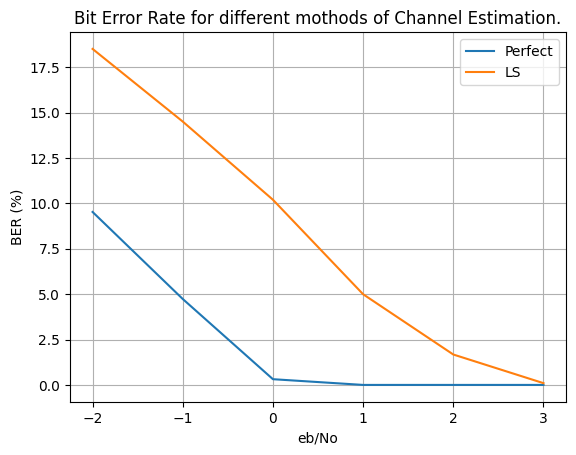

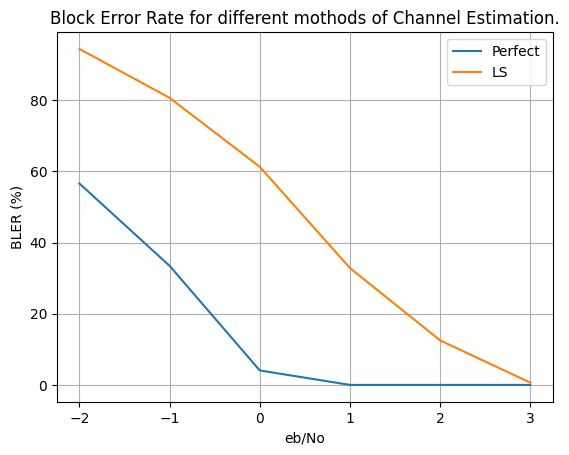

In [3]:
# Compare the results in a couple of plots:
logGraph = False
def ebNo2Snr(ebNo): return ebNo + 10*np.log10(pdsch.modems[0].qm * codeRate * bwp.dataTimeRatio)

# Bit Error Rate:
for i,chanEstMethod in enumerate(['Perfect', 'LS']):
    bers = [results[chanEstMethod][ebNo2Snr(ebNoDb)]["BER"] for ebNoDb in ebNoDbs]
    plt.plot(ebNoDbs, bers, label=chanEstMethod)
plt.legend()
plt.title("Bit Error Rate for different mothods of Channel Estimation.");
plt.grid()
plt.xlabel("eb/No")
plt.xticks(ebNoDbs)
plt.ylabel("BER (%)")
if logGraph: plt.yscale('log')
plt.show()

# Block Error rate
for i,chanEstMethod in enumerate(['Perfect', 'LS']):
    blers = [results[chanEstMethod][ebNo2Snr(ebNoDb)]["BLER"] for ebNoDb in ebNoDbs]
    plt.plot(ebNoDbs, blers, label=chanEstMethod)
plt.legend()
plt.title("Block Error Rate for different mothods of Channel Estimation.");
plt.grid()
plt.xlabel("eb/No")
plt.xticks(ebNoDbs)
plt.ylabel("BLER (%)")
if logGraph: plt.yscale('log')
plt.show()
